In [1]:
import json, time, os
from datetime import datetime
import pandas as pd


from Montecarlo import montecarlo_dias, montecarlo_base, montecarlo_viento, montecarlo_cierre, montecarlo_politica
from TraficoAEP import TraficoAviones
from TraficoAEPCierre import TraficoAEPCerrado, AEPCerrado
from TraficoAEPViento import TraficoAEPViento  
from TraficoAEPPolitica import TraficoAvionesPolitica

OUTDIR = "outputs"
os.makedirs(OUTDIR, exist_ok=True)

def save_result(df: pd.DataFrame, meta: dict, name: str) -> str:
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    base = f"{ts}_{name}"
    csv_path = os.path.join(OUTDIR, base + ".csv")
    json_path = os.path.join(OUTDIR, base + ".meta.json")
    df.to_csv(csv_path, index=False)
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)
    print("guardado:", csv_path)
    return csv_path


In [2]:
#EJ 3 
import math, random
from typing import List, Set, Tuple

from Constants import DAY_END, DAY_START
from TraficoAEP import TraficoAviones


def ic95_proporcion(p_hat: float, n: int) -> Tuple[float, float]:
    """IC 95% para una proporción (aprox normal)."""
    if n == 0:
        return (float("nan"), float("nan"))
    se = (p_hat * (1 - p_hat) / n) ** 0.5
    return (max(0.0, p_hat - 1.96 * se), min(1.0, p_hat + 1.96 * se))


def simular_jornada_3(ctrl_seed: int, lam_per_min: float) -> Tuple[List[int], List[int], int]:
    """
    Devuelve:
        - Aterrizajes por hora 
        - Arribos por hora
        - Desviados totales
    """
    ctrl = TraficoAviones(seed = ctrl_seed)
    apariciones = set(ctrl.bernoulli_aparicion(lam_per_min, t0 = DAY_START, t1= DAY_END))

    num_horas = (DAY_END - DAY_START) // 60
    arriv_h = [0] * num_horas
    land_h = [0] * num_horas

    for t in apariciones:
        h = (t - DAY_START) // 60
        if 0 <= h < num_horas:
            arriv_h[h] += 1

    def landed_set() -> Set[int]:
        return {aid for aid in ctrl.inactivos if ctrl.planes[aid].estado == "landed"}
    def diverted_set() -> Set[int]:
        return {aid for aid in ctrl.inactivos if ctrl.planes[aid].estado == "diverted"}
    

    prev_landed = set()
    for t in range(DAY_START, DAY_END):
        ctrl.step(t, aparicion=(t in apariciones))
        nuevos = landed_set() - prev_landed
        if nuevos:
            h = (t - DAY_START) // 60
            if 0 <= h < num_horas:
                land_h[h] += len(nuevos)
        prev_landed = landed_set()
    
    return land_h, arriv_h, len(diverted_set())


def montecarlo_3(lam_per_min: float = 1/60, dias: int = 90, seed:int = 123):
    
    rng = random.Random(seed)
    horas_total = 0
    horas_eq5_landed = 0
    horas_eq5_arrivals = 0
    desviados_total = 0

    for _ in range(dias):
        land_h, arriv_h, desviados = simular_jornada_3(rng.randrange(1_000_000_000), lam_per_min)
        desviados_total += desviados
        for x_l, x_a in zip(land_h, arriv_h):
            horas_total += 1
            if x_l == 5: horas_eq5_landed += 1
            if x_a ==5: horas_eq5_arrivals += 1
    
    p_l = horas_eq5_landed / horas_total if horas_total else float("nan")
    p_a = horas_eq5_arrivals / horas_total if horas_total else float("nan")

    return {
        "dias": dias,
        "lambda": lam_per_min,
        "p(X=5 aterrizajes/h)": p_l,
        "IC95 X": ic95_proporcion(p_l, horas_total),
        "p(Y=5 arribos/h)": p_a,
        "IC95 Y": ic95_proporcion(p_a, horas_total),
        "desviados_totales": desviados_total,
        "horas_observadas": horas_total,
    }

res = montecarlo_3(lam_per_min=1/60, dias = 300, seed= 123)
res

{'dias': 300,
 'lambda': 0.016666666666666666,
 'p(X=5 aterrizajes/h)': 0.0014814814814814814,
 'IC95 X': (0.00045562792864704826, 0.0025073350343159146),
 'p(Y=5 arribos/h)': 0.0038888888888888888,
 'IC95 Y': (0.002228820991797382, 0.005548956785980396),
 'desviados_totales': 173,
 'horas_observadas': 5400}

In [3]:
lams = [0.08, 0.10, 0.12, 0.14]

In [4]:

df_base = montecarlo_base(lams=lams, dias=200, seed=123)
save_result(df_base, {"scenario":"base", "lams":lams, "dias":200, "seed":123}, "base_mc")
df_base.head()


guardado: outputs\20250920-194520_base_mc.csv


,lam,congestion_rate_mean,congestion_rate_ci_low,congestion_rate_ci_high,avg_delay_min_mean,avg_delay_min_ci_low,avg_delay_min_ci_high,divert_rate_mean,divert_rate_ci_low,divert_rate_ci_high,avg_arrivals_per_day,avg_diverted_per_day,dias
0,0.08,0.075694,0.072875,0.078513,1.042879,0.970139,1.115618,0.130541,0.125910,0.135172,86.475,11.375,200
1,0.10,0.089529,0.087066,0.091992,1.549081,1.461334,1.636828,0.161046,0.156620,0.165473,108.565,17.630,200
2,0.12,0.107303,0.104734,0.109873,2.227680,2.124110,2.331250,0.192186,0.187901,0.196471,129.515,25.045,200
3,0.14,0.118811,0.116294,0.121328,2.922179,2.775731,3.068627,0.224651,0.220946,0.228357,151.330,34.155,200


In [5]:
kw = {"p_goaround": 0.10, "final_threshold_nm": 3}
df_wind = montecarlo_dias(
    lams=lams, dias = 200, seed=123,
    Controller=TraficoAEPViento, controller_kwargs=kw
)
df_wind["scenario"] = "viento"
save_result(df_wind, {"scenario":"viento", "kwargs":kw, "lams":lams, "dias":200, "seed":123}, "viento_mc")
df_wind.head()

guardado: outputs\20250920-194557_viento_mc.csv


,lam,congestion_rate_mean,congestion_rate_ci_low,congestion_rate_ci_high,avg_delay_min_mean,avg_delay_min_ci_low,avg_delay_min_ci_high,divert_rate_mean,divert_rate_ci_low,divert_rate_ci_high,avg_arrivals_per_day,avg_diverted_per_day,dias,scenario
0,0.08,0.045672,0.043022,0.048323,1.957539,1.846191,2.068887,0.159317,0.154292,0.164342,86.475,13.900,200,viento
1,0.10,0.051625,0.049207,0.054043,2.651926,2.514382,2.789470,0.201357,0.196697,0.206016,108.565,22.045,200,viento
2,0.12,0.060232,0.057762,0.062701,3.208975,3.044476,3.373475,0.243566,0.239085,0.248047,129.515,31.725,200,viento
3,0.14,0.065280,0.062944,0.067616,3.978418,3.787440,4.169396,0.281609,0.277684,0.285533,151.330,42.820,200,viento


In [6]:
import importlib
import Simulacion, TraficoAEPCierre, Montecarlo

importlib.reload(Simulacion)
importlib.reload(TraficoAEPCierre)
importlib.reload(Montecarlo)

closure = AEPCerrado(start_min=180, dur_min=30)
kwargs_cierre = {"closure": closure}

meta = {
    "scenario": "cierre",
    "kwargs": {
        "closure": {"start_min": closure.start_min, "dur_min": closure.dur_min}
    },
    "lams": lams, "dias": 200, "seed": 123
}

df_close = montecarlo_dias(
    lams=lams, dias=200, seed=123,
    Controller=TraficoAEPCerrado, controller_kwargs=kwargs_cierre
)

df_close["scenario"] = "cierre"
save_result(df_close, meta, "cierre_mc")
df_close.head()


guardado: outputs\20250920-194704_cierre_mc.csv


,lam,congestion_rate_mean,congestion_rate_ci_low,congestion_rate_ci_high,avg_delay_min_mean,avg_delay_min_ci_low,avg_delay_min_ci_high,divert_rate_mean,divert_rate_ci_low,divert_rate_ci_high,avg_arrivals_per_day,avg_diverted_per_day,dias,scenario
0,0.08,0.076869,0.074080,0.079659,1.859125,1.729921,1.988330,0.131109,0.126465,0.135753,86.475,11.425,200,cierre
1,0.10,0.090892,0.088454,0.093330,2.415214,2.288325,2.542104,0.162033,0.157642,0.166425,108.565,17.740,200,cierre
2,0.12,0.108400,0.105836,0.110965,3.205592,3.059515,3.351669,0.194762,0.190519,0.199004,129.515,25.380,200,cierre
3,0.14,0.120044,0.117543,0.122545,4.006589,3.835971,4.177207,0.228795,0.225024,0.232567,151.330,34.790,200,cierre


In [8]:
from Montecarlo import montecarlo_politica
import pandas as pd

import importlib, TraficoAEPPolitica, Simulacion, Montecarlo
importlib.reload(TraficoAEPPolitica)
importlib.reload(Simulacion)
importlib.reload(Montecarlo)

LAMBDAS = [0.02, 0.1, 0.2, 0.5]
DIAS = 200
SEED = 123

df_politica = montecarlo_politica(LAMBDAS, dias=DIAS, seed=SEED)
df_politica["scenario"] = "politica"

df_politica.to_csv("politica_mc.csv", index=False)
df_politica.head()

,lam,congestion_rate_mean,congestion_rate_ci_low,congestion_rate_ci_high,avg_delay_min_mean,avg_delay_min_ci_low,avg_delay_min_ci_high,divert_rate_mean,divert_rate_ci_low,divert_rate_ci_high,avg_arrivals_per_day,avg_diverted_per_day,dias,scenario
0,0.02,0.030639,0.027152,0.034126,0.248447,0.216738,0.280156,0.042827,0.036867,0.048788,21.710,0.965,200,politica
1,0.10,0.117253,0.114579,0.119928,1.090496,1.054076,1.126916,0.232355,0.227495,0.237216,108.565,25.445,200,politica
2,0.20,0.193019,0.190537,0.195501,1.765219,1.725369,1.805070,0.429036,0.425675,0.432396,216.070,92.960,200,politica
3,0.50,0.345488,0.343377,0.347600,2.268474,2.248452,2.288496,0.701482,0.700320,0.702645,538.870,378.145,200,politica


In [ ]:
from Montecarlo import montecarlo_politica2a
import pandas as pd

import importlib, TraficoAEPPolitica, Simulacion, Montecarlo
importlib.reload(TraficoAEPPolitica)
importlib.reload(Simulacion)
importlib.reload(Montecarlo)

LAMBDAS = [0.02, 0.1, 0.2, 0.5]
DIAS = 200
SEED = 123

df_politica = montecarlo_politica2a(LAMBDAS, dias=DIAS, seed=SEED)
df_politica["scenario"] = "politica2a"

meta = {"scenario": "politica2a", "lams": LAMBDAS, "dias": DIAS, "seed": SEED}
save_result(df_politica, meta, "politica2a_mc")
df_politica.head()

In [ ]:
from Montecarlo import montecarlo_politica2b
import pandas as pd

import importlib, TraficoAEPPolitica, Simulacion, Montecarlo
importlib.reload(TraficoAEPPolitica)
importlib.reload(Simulacion)
importlib.reload(Montecarlo)

LAMBDAS = [0.02, 0.1, 0.2, 0.5]
DIAS = 200
SEED = 123

df_politica = montecarlo_politica2b(LAMBDAS, dias=DIAS, seed=SEED)
df_politica["scenario"] = "politica2b"

meta = {"scenario": "politica2b", "lams": LAMBDAS, "dias": DIAS, "seed": SEED}
save_result(df_politica, meta, "politica2b_mc")
df_politica.head()

In [1]:
from Montecarlo import montecarlo_base, montecarlo_viento, montecarlo_cierre, montecarlo_politica
import pandas as pd

lams = [0.02, 0.1, 0.2, 0.5, 1.0]
dias = 200
seed = 123

df_base = montecarlo_base(lams, dias=dias, seed=seed).assign(scenario="base")
df_viento = montecarlo_viento(lams, dias=dias, seed=seed, p_goaround = 0.10, final_threshold_nm=3).assign(scenario = "viento")
df_cierre = montecarlo_cierre(lams, dias=dias, seed=seed, start_min=180, dur_min=30).assign(scenario="cierre")
df_pol    = montecarlo_politica(lams, dias=dias, seed=seed, buffer_anticipacion=0.5).assign(scenario="politica")

df_all = pd.concat([df_base, df_viento, df_cierre, df_pol], ignore_index=True)
df_all.head()


,lam,congestion_rate_mean,congestion_rate_ci_low,congestion_rate_ci_high,avg_delay_min_mean,avg_delay_min_ci_low,avg_delay_min_ci_high,divert_rate_mean,divert_rate_ci_low,divert_rate_ci_high,avg_arrivals_per_day,avg_diverted_per_day,dias,scenario
0,0.02,0.021195,0.018136,0.024255,0.162586,0.127529,0.197643,0.036646,0.031244,0.042048,21.710,0.825,200,base
1,0.10,0.089529,0.087066,0.091992,1.549081,1.461334,1.636828,0.161046,0.156620,0.165473,108.565,17.630,200,base
2,0.20,0.160091,0.157767,0.162415,5.340367,5.175618,5.505117,0.320116,0.316407,0.323825,216.070,69.450,200,base
3,0.50,0.304039,0.302458,0.305620,8.669002,8.510092,8.827911,0.678843,0.677233,0.680452,538.870,365.980,200,base
4,1.00,0.386164,0.386164,0.386164,2.288083,2.288083,2.288083,0.813889,0.813889,0.813889,1080.000,879.000,200,base


(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'Congestión vs λ'}, xlabel='λ (arribos por minuto)', ylabel='Proporción de minutos en congestión'>)

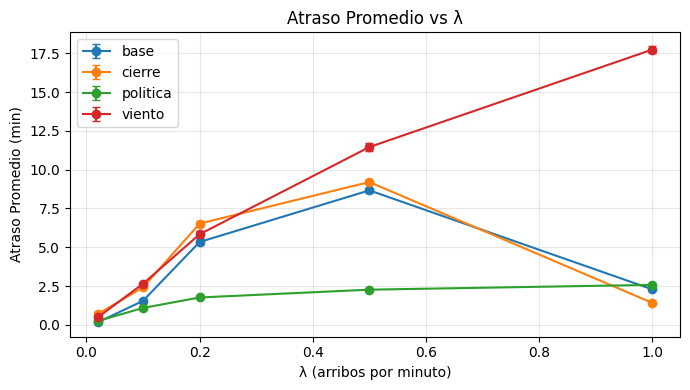

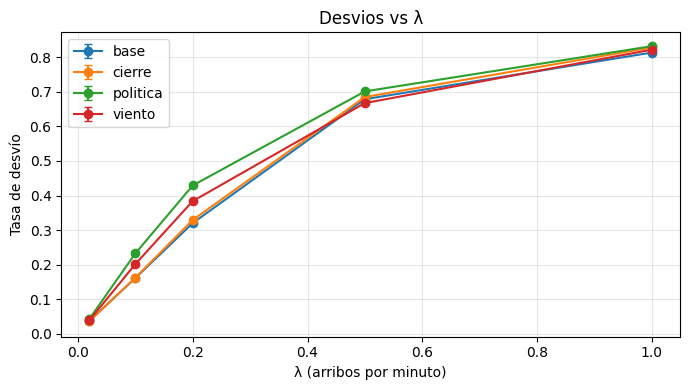

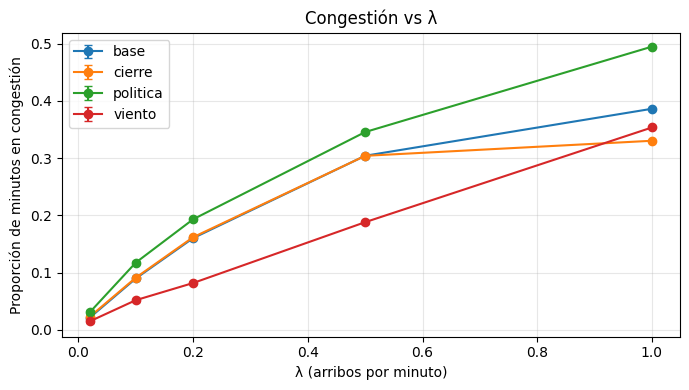

In [2]:
import Plots as V

V.plot_metric_vs_lambda(df_all, metric = "avg_delay_min",
                        ylabel= "Atraso Promedio (min)",
                        title= "Atraso Promedio vs λ",
                        outname="delay_vs_lambda")


V.plot_metric_vs_lambda(df_all, metric = "divert_rate",
                        ylabel= "Tasa de desvío",
                        title= "Desvios vs λ",
                        outname="diverts_vs_lambda")


V.plot_metric_vs_lambda(df_all, metric = "congestion_rate",
                        ylabel= "Proporción de minutos en congestión",
                        title= "Congestión vs λ",
                        outname="congestion_vs_lambda")

